# Doctor Type ML Automation
Amy Jin

July 10th, 2018

In [3]:
# Load libraries
import pandas as pd
import seaborn as sns
import numpy as np
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import RandomizedPCA
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import GaussianNB
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
# global import
import os
import sys
import numpy as np
import pandas as pd
from collections import Counter
import operator
import time
from imblearn.over_sampling import RandomOverSampler
# Connect to Parenthood server
import mysql.connector
import sshtunnel
import pureyaml


In [4]:
def GetDataFromParenthood(db_name, table_name):
    
    # handle path
    project_dir = !pwd  # dir of current script/notebook file
    config_file = open(project_dir[0] + "/db.yaml")
    config = pureyaml.load(config_file.read())
    config_file2 = open(project_dir[0] + "/db2.yaml")
    config2 = pureyaml.load(config_file2.read())

    # argument dictionary for sshtunnel
    ssh_config = {
        'ssh_address_or_host': ('parenthood.set.care', 22),
        'ssh_username':        config['ssh_username'],
        'ssh_password':        config['ssh_password'],
        'remote_bind_address': ('127.0.0.1', 3306),
        'local_bind_address':  ('0.0.0.0', 3333),
    }

    # argument dictionary for mysql.connector
    mysql_config = {
        'user':     config['mysql_user'],
        'password': config['mysql_passwd'],
        'host':     config['mysql_host'],
        'database': 'patch',
        'port':     3333,
    }  
    
    #table1 = str(db_name) + '.' + str(table_name)
    with sshtunnel.SSHTunnelForwarder(**ssh_config) as tunnel:
        connection = mysql.connector.connect(**mysql_config)
        cur = connection.cursor()
        
        # Use `DISTINCT` to reduce the calculation load
        query = ('''
            SELECT *
            FROM {db}.{t1} AS A;
        '''.format(db = db_name, t1 = table_name))

        cur.execute(query)
        rows = list(sum(cur.fetchall(), ()))
        #print rows, len(rows)
        #df = pd.DataFrame(rows)
        #print df
        #print df.shape
        
        # Get columans 
        colnames = ['npi', 'Y_is_oncologist', 'Certification', 'patient_count']
        for i in range(1, 11):  # do the following 10 times:
            colnames.append('X' + str(i))

        # Transform a long list to a (n, 14) dataframe
        # -1 simply means that it is an unknown dimension and we want numpy to figure it out.
        df_reformat =  pd.DataFrame(np.array(rows).reshape(-1, 14), columns=colnames)
        return df_reformat
            
        cur.close()
        connection.close()

In [ ]:
#tic = time.clock()
#data = GetDataFromParenthood('_phu', 'TeamingByOtherTaxonomy')
#toc = time.clock()
#toc - tic

In [4]:
data = pd.read_csv("/Users/yuejin/Desktop/PMSA_hop_ml_12182018/HOP_NPI_Tax_ML.csv")

In [5]:
data.head(3)

,from_npi_tax_cd,patient_count_101y00000x,npi_count_101y00000x,patient_count_101ya0400x,npi_count_101ya0400x,patient_count_101ym0800x,npi_count_101ym0800x,patient_count_101yp1600x,npi_count_101yp1600x,patient_count_101yp2500x,...,patient_count_385hr2055x,npi_count_385hr2055x,patient_count_385hr2060x,npi_count_385hr2060x,patient_count_385hr2065x,npi_count_385hr2065x,patient_count_390200000x,npi_count_390200000x,patient_count_405300000x,npi_count_405300000x
0,207R00000X,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,207ZP0102X,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,15,1,0,0
2,207L00000X,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
print data.dtypes.head(10)
print data.shape

from_npi_tax_cd             object
patient_count_101y00000x     int64
npi_count_101y00000x         int64
patient_count_101ya0400x     int64
npi_count_101ya0400x         int64
patient_count_101ym0800x     int64
npi_count_101ym0800x         int64
patient_count_101yp1600x     int64
npi_count_101yp1600x         int64
patient_count_101yp2500x     int64
dtype: object
(1448051, 1445)


In [7]:
tax_group_count = data.groupby('from_npi_tax_cd').agg({'from_npi_tax_cd':'count'}).sort_values(by = 'from_npi_tax_cd', ascending=False)

/Users/yuejin/miniconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 'from_npi_tax_cd' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  """Entry point for launching an IPython kernel.


In [8]:
print tax_group_count

                 from_npi_tax_cd
from_npi_tax_cd                 
207Q00000X                106838
207R00000X                101064
363LF0000X                 67597
225100000X                 57946
363A00000X                 53048
111N00000X                 50804
367500000X                 43777
207P00000X                 42887
152W00000X                 41150
207L00000X                 38076
363L00000X                 30171
2085R0202X                 29548
207V00000X                 26716
3336C0003X                 26401
174400000X                 25899
2084P0800X                 23032
207RC0000X                 21905
208600000X                 21436
207W00000X                 21045
314000000X                 20206
207X00000X                 19098
333600000X                 19039
363AM0700X                 18992
1041C0700X                 18448
207RG0100X                 15215
2084N0400X                 14297
390200000X                 13369
363LA2200X                 12803
208M00000X

## Select top 10 high frequency tax data

In [10]:
tax_group_count.index

Index([u'207Q00000X', u'207R00000X', u'363LF0000X', u'225100000X',
       u'363A00000X', u'111N00000X', u'367500000X', u'207P00000X',
       u'152W00000X', u'207L00000X',
       ...
       u'225XF0002X', u'2080C0008X', u'125Q00000X', u'225XH1300X',
       u'335G00000X', u'2278C0205X', u'2278H0200X', u'175T00000X',
       u'2278P3800X', u'246Y00000X'],
      dtype='object', name=u'from_npi_tax_cd', length=722)

In [11]:
tax_list_10 = [u'207Q00000X', u'207R00000X', u'363LF0000X', u'225100000X',
       u'363A00000X', u'111N00000X', u'367500000X', u'207P00000X',
       u'152W00000X', u'207L00000X']

In [13]:
data_tax_10 = data[data['from_npi_tax_cd'].isin(tax_list_10)]

In [14]:
data_tax_10.shape

(603187, 1445)

In [20]:
data_tax_10.head(10)

,from_npi_tax_cd,patient_count_101y00000x,npi_count_101y00000x,patient_count_101ya0400x,npi_count_101ya0400x,patient_count_101ym0800x,npi_count_101ym0800x,patient_count_101yp1600x,npi_count_101yp1600x,patient_count_101yp2500x,...,patient_count_385hr2055x,npi_count_385hr2055x,patient_count_385hr2060x,npi_count_385hr2060x,patient_count_385hr2065x,npi_count_385hr2065x,patient_count_390200000x,npi_count_390200000x,patient_count_405300000x,npi_count_405300000x
0,207R00000X,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,207L00000X,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,111N00000X,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,152W00000X,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,207Q00000X,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13,207R00000X,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17,207L00000X,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,12,1,0,0
18,363LF0000X,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19,363A00000X,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21,225100000X,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
data_tax_10.groupby('from_npi_tax_cd').agg({'from_npi_tax_cd':'count'}).sort_values(by = 'from_npi_tax_cd', ascending=False)

/Users/yuejin/miniconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 'from_npi_tax_cd' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  """Entry point for launching an IPython kernel.


,from_npi_tax_cd
from_npi_tax_cd,
207Q00000X,106838
207R00000X,101064
363LF0000X,67597
225100000X,57946
363A00000X,53048
111N00000X,50804
367500000X,43777
207P00000X,42887
152W00000X,41150


In [ ]:
#data_tax_10.to_csv(path_or_buf='/Users/yuejin/Desktop/PMSA_hop_ml_12182018/HOP_NPI_Tax10_ML.csv', 
#                   sep=',', na_rep='', float_format=None, columns=None, 
#                   header=True, index=False, index_label=None, mode='w', 
#                   encoding=None, compression=None, quoting=None, quotechar='"', 
#                   line_terminator='\n', chunksize=None, tupleize_cols=None, date_format=None, 
#                   doublequote=True, escapechar=None, decimal='.')
data_tax_10_read = pd.read_csv("/Users/yuejin/Desktop/PMSA_hop_ml_12182018/HOP_NPI_Tax10_ML.csv") #same as data_tax_10
data_tax_10_read.head(10)

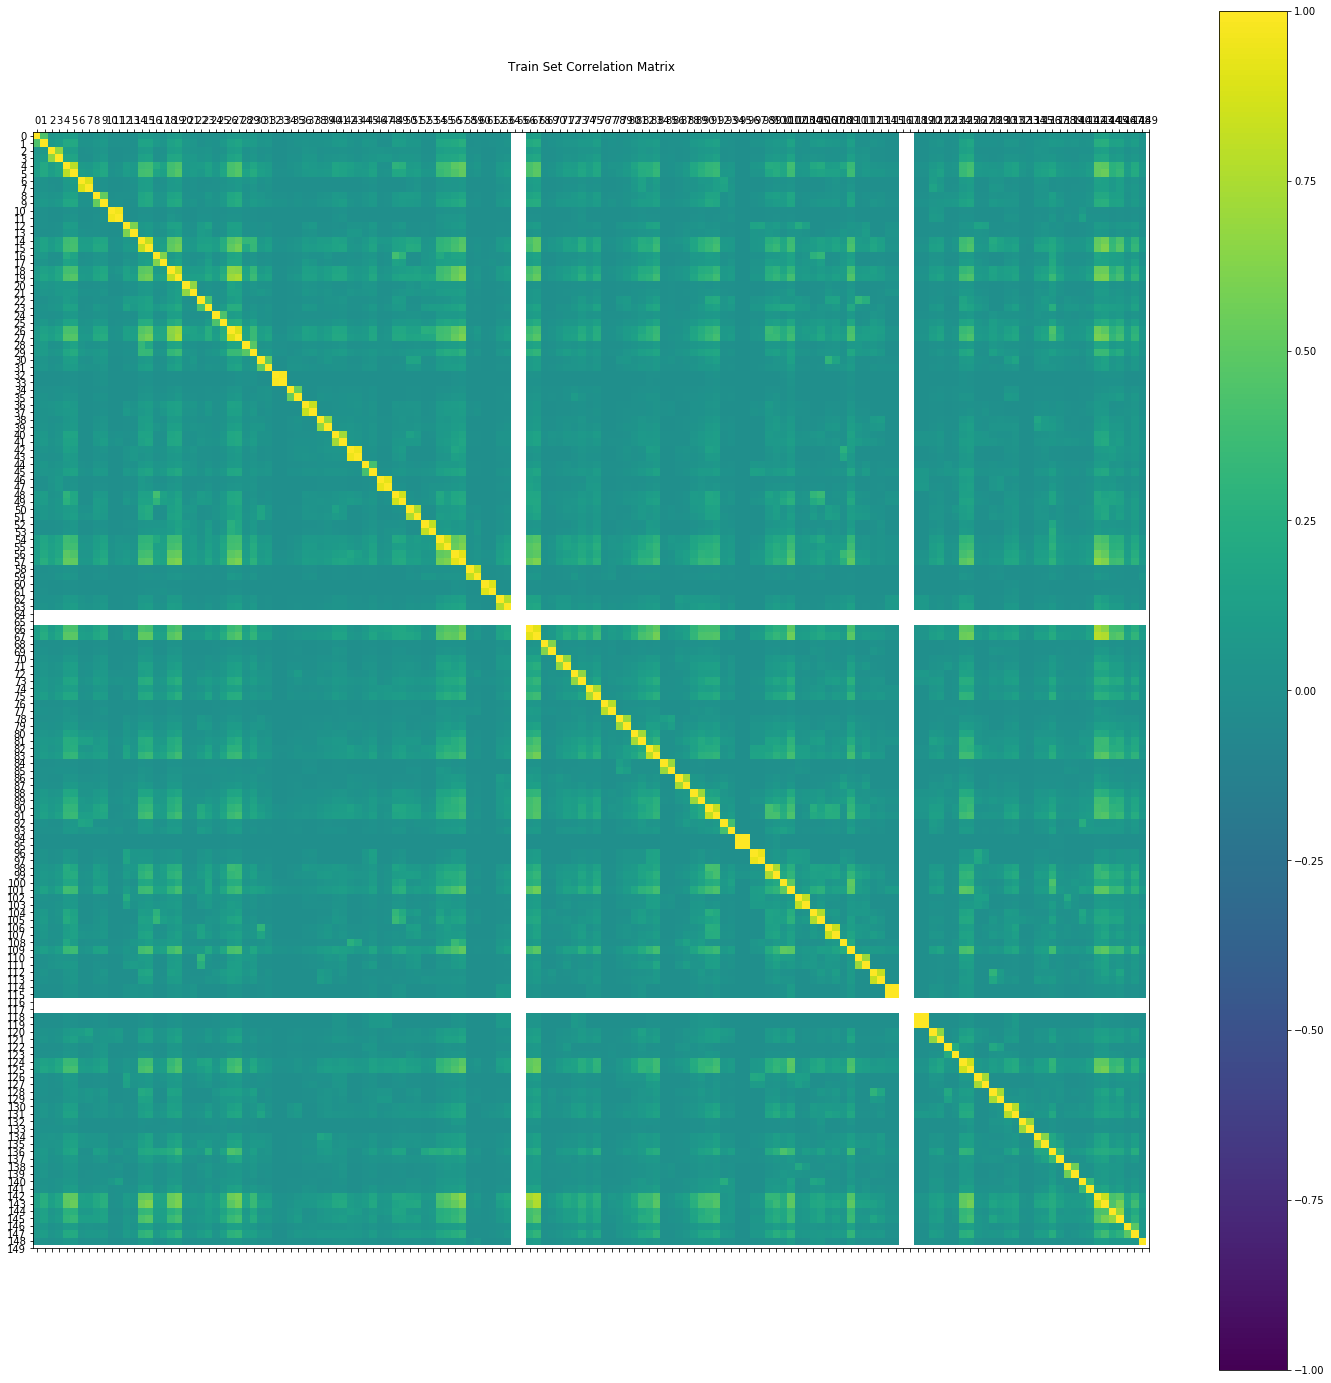

In [54]:
# Correction Matrix Plot
train_cor = data_tax_10.iloc[:,1:150]
correlations = train_cor.corr()

# plot correlation matrix
plt.rcParams["figure.figsize"] = [25,25]
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,150,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
plt.title('Train Set Correlation Matrix')
plt.show()

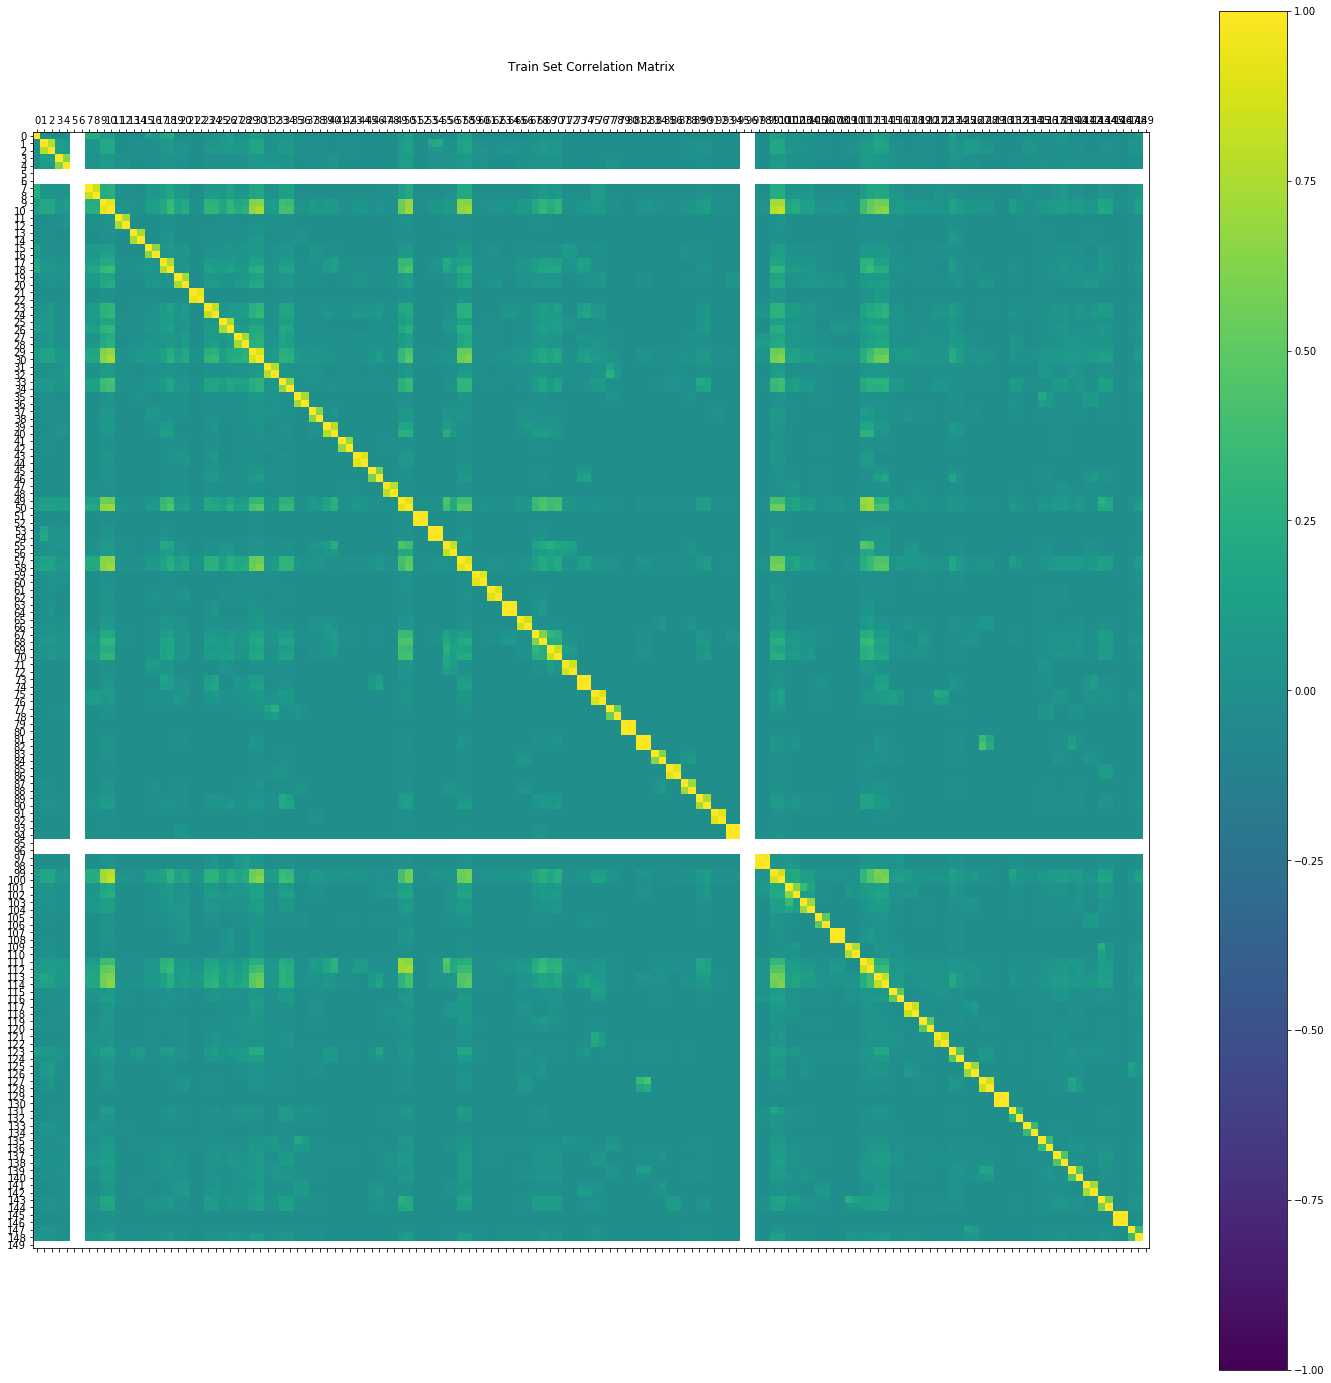

In [53]:
# Correction Matrix Plot
train_cor = data_tax_10.iloc[:,800:950]
correlations = train_cor.corr()

# plot correlation matrix
plt.rcParams["figure.figsize"] = [25,25]
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,150,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
plt.title('Train Set Correlation Matrix')
plt.show()

From the correlation plots it's obvious that most of patient count columns and npi count colums are highly correlated. So to start from simple models, we may try to use the patient count only to do the machine learning. Then try to add npi count columns to see if they help.  

Besides, there are some columns all all zero, we should drop these columns since they are not helpful and take up space.

In [5]:
data_tax_10 = pd.read_csv("/Users/yuejin/Desktop/PMSA_hop_ml_12182018/HOP_NPI_Tax10_ML.csv")

In [8]:
data_tax_10_patient_only = data_tax_10.iloc[:,1::2]

In [22]:
data_tax_10_patient_only.head(5)

,patient_count_101y00000x,patient_count_101ya0400x,patient_count_101ym0800x,patient_count_101yp1600x,patient_count_101yp2500x,patient_count_101ys0200x,patient_count_102l00000x,patient_count_103g00000x,patient_count_103k00000x,patient_count_103t00000x,...,patient_count_374u00000x,patient_count_376g00000x,patient_count_376j00000x,patient_count_376k00000x,patient_count_385h00000x,patient_count_385hr2055x,patient_count_385hr2060x,patient_count_385hr2065x,patient_count_390200000x,patient_count_405300000x
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
data_tax_10_y = data_tax_10.iloc[:,0]

In [23]:
data_tax_10_y = data_tax_10['from_npi_tax_cd']

In [24]:
data_tax_10_y.head(5)

0    207R00000X
1    207L00000X
2    111N00000X
3    152W00000X
4    207Q00000X
Name: from_npi_tax_cd, dtype: object

In [31]:
data_tax_10_patient = pd.concat([data_tax_10_y, data_tax_10_patient_only], axis=1)

In [32]:
data_tax_10_patient.to_csv(path_or_buf='/Users/yuejin/Desktop/PMSA_hop_ml_12182018/data_tax_10_patient.csv', 
                   sep=',', na_rep='', float_format=None, columns=None, 
                   header=True, index=False, index_label=None, mode='w', 
                   encoding=None, compression=None, quoting=None, quotechar='"', 
                   line_terminator='\n', chunksize=None, tupleize_cols=None, date_format=None, 
                   doublequote=True, escapechar=None, decimal='.')

In [33]:
data_tax_10_patient_read = pd.read_csv("/Users/yuejin/Desktop/PMSA_hop_ml_12182018/data_tax_10_patient.csv") 

In [34]:
data_tax_10_patient_read.shape

(603187, 723)

In [35]:
data_tax_10_patient_read.head(5)

,from_npi_tax_cd,patient_count_101y00000x,patient_count_101ya0400x,patient_count_101ym0800x,patient_count_101yp1600x,patient_count_101yp2500x,patient_count_101ys0200x,patient_count_102l00000x,patient_count_103g00000x,patient_count_103k00000x,...,patient_count_374u00000x,patient_count_376g00000x,patient_count_376j00000x,patient_count_376k00000x,patient_count_385h00000x,patient_count_385hr2055x,patient_count_385hr2060x,patient_count_385hr2065x,patient_count_390200000x,patient_count_405300000x
0,207R00000X,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,207L00000X,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,111N00000X,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,152W00000X,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,207Q00000X,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [36]:
data_tax_10_patient_nonzero = data_tax_10_patient_read.loc[:, (data_tax_10_patient_read != 0).any(axis=0)]

In [37]:
data_tax_10_patient_nonzero.shape

(603187, 704)

In [38]:
data_tax_10_patient_nonzero.head(5)

,from_npi_tax_cd,patient_count_101y00000x,patient_count_101ya0400x,patient_count_101ym0800x,patient_count_101yp1600x,patient_count_101yp2500x,patient_count_101ys0200x,patient_count_102l00000x,patient_count_103g00000x,patient_count_103k00000x,...,patient_count_374u00000x,patient_count_376g00000x,patient_count_376j00000x,patient_count_376k00000x,patient_count_385h00000x,patient_count_385hr2055x,patient_count_385hr2060x,patient_count_385hr2065x,patient_count_390200000x,patient_count_405300000x
0,207R00000X,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,207L00000X,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,111N00000X,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,152W00000X,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,207Q00000X,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


After filtering out NPI count columns and the zero columns, the data (data_tax_10_patient_nonzero) has been reduced to (603187, 704).

In [39]:
data_tax_10_patient_nonzero.to_csv(path_or_buf='/Users/yuejin/Desktop/PMSA_hop_ml_12182018/data_tax_10_patient_nonzero.csv', 
                   sep=',', na_rep='', float_format=None, columns=None, 
                   header=True, index=False, index_label=None, mode='w', 
                   encoding=None, compression=None, quoting=None, quotechar='"', 
                   line_terminator='\n', chunksize=None, tupleize_cols=None, date_format=None, 
                   doublequote=True, escapechar=None, decimal='.')

In [40]:
data_tax_10_patient_nonzero_read = pd.read_csv("/Users/yuejin/Desktop/PMSA_hop_ml_12182018/data_tax_10_patient_nonzero.csv") 

In [41]:
data_tax_10_patient_nonzero_read.shape

(603187, 704)

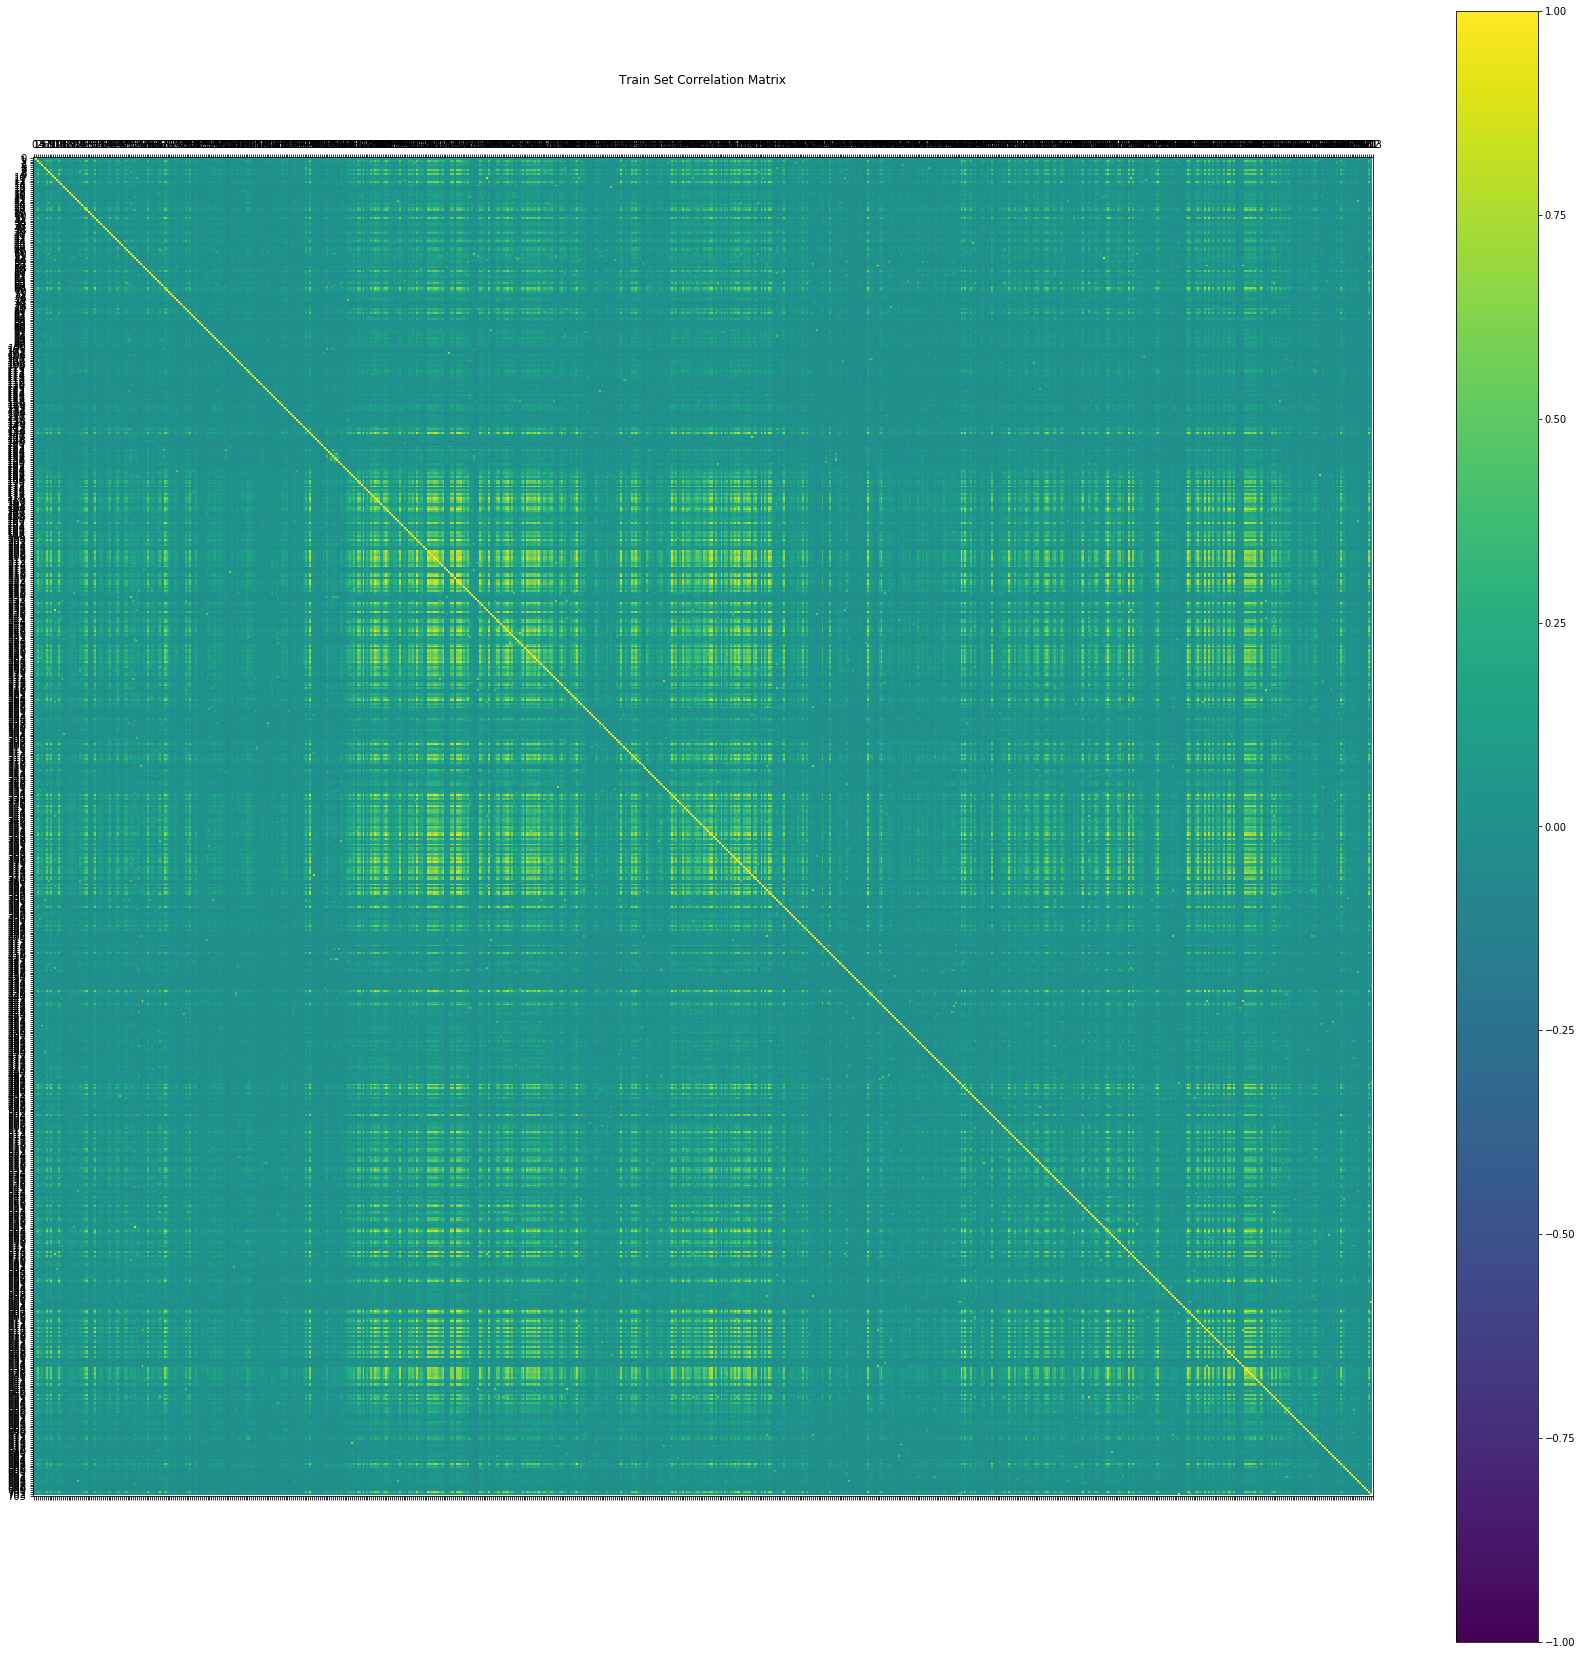

In [44]:
# Correction Matrix Plot
train_cor = data_tax_10_patient_nonzero.iloc[:,0:704]
correlations = train_cor.corr()

# plot correlation matrix
plt.rcParams["figure.figsize"] = [30,30]
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,704,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
plt.title('Train Set Correlation Matrix')
plt.show()

## Split Data into Train and Test Sets
We will split the loaded dataset (data_tax_10_patient_nonzero) into two, 80% of which we will use to train and validate our models and 20% that we will hold back as a test dataset.

In [45]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data_tax_10_patient_nonzero, test_size=0.2)

In [46]:
print train.shape
print test.shape

(482549, 704)
(120638, 704)


In [47]:
print(train.groupby('from_npi_tax_cd').size())

from_npi_tax_cd
111N00000X    40585
152W00000X    32998
207L00000X    30549
207P00000X    34327
207Q00000X    85465
207R00000X    80782
225100000X    46229
363A00000X    42545
363LF0000X    54038
367500000X    35031
dtype: int64


In [48]:
print(test.groupby('from_npi_tax_cd').size())

from_npi_tax_cd
111N00000X    10219
152W00000X     8152
207L00000X     7527
207P00000X     8560
207Q00000X    21373
207R00000X    20282
225100000X    11717
363A00000X    10503
363LF0000X    13559
367500000X     8746
dtype: int64


In [49]:
train.describe()

,patient_count_101y00000x,patient_count_101ya0400x,patient_count_101ym0800x,patient_count_101yp1600x,patient_count_101yp2500x,patient_count_101ys0200x,patient_count_102l00000x,patient_count_103g00000x,patient_count_103k00000x,patient_count_103t00000x,...,patient_count_374u00000x,patient_count_376g00000x,patient_count_376j00000x,patient_count_376k00000x,patient_count_385h00000x,patient_count_385hr2055x,patient_count_385hr2060x,patient_count_385hr2065x,patient_count_390200000x,patient_count_405300000x
count,482549.000000,482549.000000,482549.000000,482549.000000,482549.000000,482549.000000,482549.000000,482549.000000,482549.000000,482549.000000,...,482549.000000,482549.000000,482549.000000,482549.000000,482549.000000,482549.000000,482549.000000,482549.000000,482549.000000,482549.000000
mean,0.157511,0.038697,0.433181,0.000723,0.086642,0.000232,0.015659,0.477183,0.011533,1.730003,...,0.006337,0.008405,0.002849,0.001030,0.015847,0.000025,0.000128,0.000251,16.104653,0.023651
std,6.371205,1.498139,6.909917,0.142311,3.174968,0.075161,1.208697,9.855866,0.970659,23.401298,...,0.612736,0.963458,0.528244,0.266503,1.460833,0.017275,0.045750,0.083258,207.747642,3.555800
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2491.000000,302.000000,1049.000000,54.000000,1486.000000,29.000000,400.000000,1529.000000,256.000000,3354.000000,...,155.000000,275.000000,295.000000,147.000000,714.000000,12.000000,19.000000,40.000000,66107.000000,2342.000000


In [6]:
def Model_Logistic(data):
    
    train, test = train_test_split(data, test_size=0.2, random_state = 100)
    X_train = train.iloc[:,4:14]
    y_train = train.iloc[:,1]
    X_data = data.iloc[:,4:14]
    y_data = data.iloc[:,1]
    
    ros = RandomOverSampler(random_state=0)
    X_resampled, y_resampled = ros.fit_sample(X_train, y_train)
    
    logisticRegr = LogisticRegression(random_state=0)
    X_resampled = pd.DataFrame(X_resampled)
    logisticRegr.fit(X_resampled.iloc[:,[0,1,2,4,5,9]], y_resampled)
    y_data_pred = logisticRegr.predict(X_data.iloc[:,[0,1,2,4,5,9]])
    
    confusion_mtx = confusion_matrix(y_data, y_data_pred)
    print "Confusion Matrix for Logistic Regression with 6 features is:"
    print(confusion_mtx)
    return y_data_pred
    #return confusion_mtx

In [ ]:
logist_pred = Model_Logistic(data)
print logist_pred

In [42]:
def Model_Tree(data):
    
    train, test = train_test_split(data, test_size=0.2, random_state = 100)
    X_train = train.iloc[:,4:14]
    y_train = train.iloc[:,1]
    X_data = data.iloc[:,4:14]
    y_data = data.iloc[:,1]
        
    ros = RandomOverSampler(random_state=0)
    X_resampled, y_resampled = ros.fit_sample(X_train, y_train)
    
    clf_gini_3 = DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
    clf_gini_3.fit(X_resampled, y_resampled)
    y_data_pred = clf_gini_3.predict(X_data)

    confusion_mtx = confusion_matrix(y_data, y_data_pred)
    print "Confusion Matrix for Decision Tree with Gini Index is:"
    print(confusion_mtx)
    return y_data_pred
    #return confusion_mtx

In [43]:
tree_pred = Model_Tree(data)
print tree_pred

Confusion Matrix for Decision Tree with Gini Index is:
[[185363     41]
 [   401    188]]
[u'0' u'0' u'0' ... u'0' u'0' u'0']


In [44]:
def Model_RF(data):
    
    train, test = train_test_split(data, test_size=0.2, random_state = 100)
    X_train = train.iloc[:,4:14]
    y_train = train.iloc[:,1]
    X_data = data.iloc[:,4:14]
    y_data = data.iloc[:,1]

    clf_RF = RandomForestClassifier(n_estimators=100)
    #Train the model using the training sets y_pred=clf.predict(X_test)
    clf_RF.fit(X_train,y_train)

    y_data_pred=clf_RF.predict(X_data)

    confusion_mtx = confusion_matrix(y_data, y_data_pred)
    print "Confusion Matrix for Random Forest with Gini Index is:"
    print(confusion_mtx)
    return y_data_pred
    #return confusion_mtx

In [45]:
RF_pred = Model_RF(data)
print RF_pred

Confusion Matrix for Random Forest with Gini Index is:
[[185394     10]
 [   407    182]]
[u'0' u'0' u'0' ... u'0' u'0' u'0']


In [47]:
def Model_NaiveBayes(data):
    
    train, test = train_test_split(data, test_size=0.2, random_state = 100)
    X_train = train.iloc[:,4:14]
    y_train = train.iloc[:,1]
    X_data = data.iloc[:,4:14]
    y_data = data.iloc[:,1]

    GNB = GaussianNB()
    GNB.fit(X_train, y_train)
    y_data_pred = GNB.predict(X_data)
    
    confusion_mtx = confusion_matrix(y_data, y_data_pred)
    print "Confusion Matrix for Naive Bayes is:"
    print(confusion_mtx)
    return y_data_pred
    #return confusion_mtx

In [48]:
NB_pred = Model_NaiveBayes(data)
print NB_pred

Confusion Matrix for Naive Bayes is:
[[182477   2927]
 [   383    206]]
[u'0' u'0' u'0' ... u'0' u'0' u'0']


In [57]:
def Model_SVM_sigmoid(data):
    
    train, test = train_test_split(data, test_size=0.2, random_state = 100)
    X_train = train.iloc[:,4:14]
    y_train = train.iloc[:,1]
    X_data = data.iloc[:,4:14]
    y_data = data.iloc[:,1]
    
    pca = PCA(n_components=2)
    pca.fit(X_train)
    X_pca = pca.transform(X_train)
    train_2d = pca.transform(X_train)
    data_2d = pca.transform(X_data)
    
    pca = RandomizedPCA(n_components=150, whiten=True, random_state=42)
    sigmoid_SVM = SVC(kernel='sigmoid')
    sigmoid_SVM.fit(train_2d, y_train)
    y_data_pred = sigmoid_SVM.predict(data_2d)
    
    confusion_mtx = confusion_matrix(y_data, y_data_pred)
    print "Confusion Matrix for SVM with sigmoid kernel is:"
    print(confusion_mtx)
    return y_data_pred
    #return confusion_mtx

In [58]:
SVM_sigmoid_pred = Model_SVM_sigmoid(data)
print SVM_sigmoid_pred

Confusion Matrix for SVM with sigmoid kernel is:
[[185404      0]
 [   589      0]]
[u'0' u'0' u'0' ... u'0' u'0' u'0']


In [61]:
def Model_SVM_linear(data, C):
    
    train, test = train_test_split(data, test_size=0.2, random_state = 100)
    X_train = train.iloc[:,4:14]
    y_train = train.iloc[:,1]
    X_data = data.iloc[:,4:14]
    y_data = data.iloc[:,1]
    
    pca = PCA(n_components=2)
    pca.fit(X_train)
    X_pca = pca.transform(X_train)
    train_2d = pca.transform(X_train)
    data_2d = pca.transform(X_data)
    
    pca = RandomizedPCA(n_components=150, whiten=True, random_state=42)
    linear_SVM = SVC(kernel='linear', class_weight='balanced', C = 1)
    linear_SVM.fit(train_2d, y_train)
    y_data_pred = linear_SVM.predict(data_2d)


    confusion_mtx = confusion_matrix(y_data, y_data_pred)
    print "Confusion Matrix for SVM with linear kernel is:"
    print(confusion_mtx)
    return y_data_pred
    #return confusion_mtx

In [62]:
SVM_linear_pred = Model_SVM_linear(data, 1)
print SVM_linear_pred

Confusion Matrix for SVM with linear kernel is:
[[180569   4835]
 [   481    108]]
[u'0' u'0' u'0' ... u'0' u'0' u'0']


In [63]:
def Model_kNN_linear(data, n_neighbors):
    
    train, test = train_test_split(data, test_size=0.2, random_state = 100)
    X_train = train.iloc[:,4:14]
    y_train = train.iloc[:,1]
    X_data = data.iloc[:,4:14]
    y_data = data.iloc[:,1]
    
    knn = KNeighborsClassifier(n_neighbors=3)
    # fitting the model
    knn.fit(X_train, y_train)
    # predict the response
    y_data_pred = knn.predict(X_data)
    
    confusion_mtx = confusion_matrix(y_data, y_data_pred)
    print "Confusion Matrix for kNN is:"
    print(confusion_mtx)
    return y_data_pred
    #return confusion_mtx

In [64]:
kNN_pred = Model_kNN_linear(data, 10)
print kNN_pred

Confusion Matrix for kNN is:
[[185373     31]
 [   532     57]]
[u'0' u'0' u'0' ... u'0' u'0' u'0']


In [65]:
def Model_LDA_linear(data):
    
    train, test = train_test_split(data, test_size=0.2, random_state = 100)
    X_train = train.iloc[:,4:14]
    y_train = train.iloc[:,1]
    X_data = data.iloc[:,4:14]
    y_data = data.iloc[:,1]

    lda = LinearDiscriminantAnalysis()
    model_lda = lda.fit(X_train, y_train)
    y_data_pred=model_lda.predict(X_data)

    confusion_mtx = confusion_matrix(y_data, y_data_pred)
    print "Confusion Matrix for LDA is:"
    print(confusion_mtx)
    return y_data_pred
    #return confusion_mtx

In [66]:
LDA_pred = Model_LDA_linear(data)
print LDA_pred

Confusion Matrix for LDA is:
[[184042   1362]
 [   395    194]]
[u'0' u'0' u'0' ... u'0' u'0' u'0']


In [70]:
def Model_QDA_linear(data):
    
    train, test = train_test_split(data, test_size=0.2, random_state = 100)
    X_train = train.iloc[:,4:14]
    y_train = train.iloc[:,1]
    X_data = data.iloc[:,4:14]
    y_data = data.iloc[:,1]
    
    qda = QuadraticDiscriminantAnalysis()
    model_qda = qda.fit(X_train, y_train)
    y_data_pred=model_qda.predict(X_data)

    confusion_mtx = confusion_matrix(y_data, y_data_pred)
    print "Confusion Matrix for QDA is:"
    print(confusion_mtx)
    return y_data_pred
    #return confusion_mtx

In [71]:
QDA_pred = Model_QDA_linear(data)
print QDA_pred

Confusion Matrix for QDA is:
[[182389   3015]
 [   379    210]]
[u'0' u'0' u'0' ... u'0' u'0' u'0']


In [72]:
def Model_GBM_linear(data, n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0):
    
    train, test = train_test_split(data, test_size=0.2, random_state = 100)
    X_train = train.iloc[:,4:14]
    y_train = train.iloc[:,1]
    X_data = data.iloc[:,4:14]
    y_data = data.iloc[:,1]
    
    model_BGM= GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
    # Train the model using the training sets and check score
    model_BGM.fit(X_train, y_train)
    y_data_pred = model_BGM.predict(X_data)
    
    confusion_mtx = confusion_matrix(y_data, y_data_pred)
    print "Confusion Matrix for GBM is:"
    print(confusion_mtx)
    return y_data_pred
    #return confusion_mtx

In [73]:
GBM_pred = Model_GBM_linear(data)
print GBM_pred

Confusion Matrix for GBM is:
[[184253   1151]
 [   399    190]]
[u'0' u'0' u'0' ... u'0' u'0' u'0']


In [91]:
def Model_XGBoost_linear(data):
    
    train, test = train_test_split(data, test_size=0.2, random_state = 100)
    X_train = train.iloc[:,4:14]
    y_train = train.iloc[:,1]
    X_data = data.iloc[:,4:14]
    y_data = data.iloc[:,1]
    #print X_train.dtypes
    
    model_XGB = XGBClassifier()
    model_XGB.fit(X_train, y_train)
    y_data_pred = model_XGB.predict(X_data)
    
    confusion_mtx = confusion_matrix(y_data, y_data_pred)
    print "Confusion Matrix for XGBoost is:"
    print(confusion_mtx)
    return y_data_pred
    #return confusion_mtx

In [92]:
XGBoost_pred = Model_XGBoost_linear(data)
print XGBoost_pred

Confusion Matrix for XGBoost is:
[[185397      7]
 [   573     16]]
[0 0 0 ... 0 0 0]


In [9]:
def UploadPredictionsToParenthood(db_name, db_table_name, table_to_upload):

    # handle path
    project_dir = !pwd  # dir of current script/notebook file
    config_file = open(project_dir[0] + "/db.yaml")
    config = pureyaml.load(config_file.read())
    config_file2 = open(project_dir[0] + "/db2.yaml")
    config2 = pureyaml.load(config_file2.read())

    # argument dictionary for sshtunnel
    ssh_config = {
        'ssh_address_or_host': ('parenthood.set.care', 22),
        'ssh_username':        config['ssh_username'],
        'ssh_password':        config['ssh_password'],
        'remote_bind_address': ('127.0.0.1', 3306),
        'local_bind_address':  ('0.0.0.0', 3333),
    }

    # argument dictionary for mysql.connector
    mysql_config = {
        'user':     config['mysql_user'],
        'password': config['mysql_passwd'],
        'host':     config['mysql_host'],
        'database': 'patch',
        'port':     3333,
    }       
    #table1 = str(db_name) + '.' + str(table_name)
    with sshtunnel.SSHTunnelForwarder(**ssh_config) as tunnel:

        connection = mysql.connector.connect(**mysql_config)
        cur = connection.cursor()
        
        # Import dataframe into MySQL
        import sqlalchemy
        database_username = config2['database_username']
        database_password = config2['database_password']
        database_ip       = config2['database_ip']
        database_name     = db_name
    
        database_connection = sqlalchemy.create_engine('mysql+pymysql://{0}:{1}@{2}/{3}'.
                                                       format(database_username, database_password, 
                                                              database_ip, database_name))
        table_to_upload.to_sql(con=database_connection, name= db_table_name, if_exists='replace')
        print "Table has been uploaded successfully!"
            
        cur.close()
        connection.close()


In [10]:
UploadPredictionsToParenthood('ml_provider_type','test_table_2', test_df_2)

Table has been uploaded successfully!
